In [23]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [24]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### Logistic Regression: Formula Label Prediction (multi-label, all features)

In [25]:
import numpy as np 
import pandas as pd
from pathlib import Path 
import ast

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()
wandb_project_name = "multi_label_formula_classification"

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [27]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    def cell_str_to_list(cell_val):
        return ast.literal_eval(cell_val)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)
    corpus["tokens"] = corpus["tokens"].map(process_cell)
    corpus["mtype_one_hot"] = corpus["mtype_one_hot"].map(cell_str_to_list)
    corpus["labels"] = corpus["labels"].map(cell_str_to_list)
    corpus = corpus.loc[(corpus["tokens"].str.len() > 0) & (corpus["tokens"] != " ")]


In [28]:
#print(os.getcwd())
data_p = Path("../data/") / "multi_class_unbalanced_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()

,tokens,type_tokens,labels,labels_str,mtype_one_hot
0,f,func_name __ANON_1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
1,j : \mathbb{N} \rightarrow [ 0 1 ],func_def func_name __ANON_1 COLON mapping set_...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
2,b,func_name __ANON_1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
3,mathbb{Q,set_constant SET_BASIC,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[1, 0, 0]"
4,f,func_name __ANON_1,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['functions', 'elementary-set-theory']","[0, 0, 1]"


In [29]:
print(data["type_tokens"].map(lambda x: len((x.split(" ")))).max())
print(data["tokens"].map(lambda x: len((x.split(" ")))).max())

254
252


In [30]:
# ordinary datasets
SMALL_TRAIN_SIZE = 24620 - 2460
SMALL_TEST_SIZE = 2460
LARGE_TRAIN_SIZE = 106523 - 10650
LARGE_TEST_SIZE = 10650
# compact datasets
NUM_CLASSES = 40

labels_array = np.array(data["labels"].to_list())
m_type_array = np.array(data["mtype_one_hot"].to_list())
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"],data["type_tokens"],m_type_array))
labels_ds = tf.data.Dataset.from_tensor_slices(labels_array)
data_as_ds = tf.data.Dataset.zip((data_as_ds, labels_ds))

test_dataset = data_as_ds.take(SMALL_TEST_SIZE)
train_dataset = data_as_ds.skip(SMALL_TEST_SIZE)

In [31]:
data_as_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(3,), dtype=tf.int64, name=None)),
 TensorSpec(shape=(40,), dtype=tf.int64, name=None))

##### Setup and Data Preparation

In [32]:
for (example_token, example_type, example_m_type), label in train_dataset.take(5):
    print("text: ", example_token.numpy())
    print("type: ", example_type.numpy())
    print("m_type: ", example_m_type.numpy())
    print("label: ", label.numpy())

text:  b'{ 2   4 }'
type:  b'explset L_BRACE_LITERAL set_enumeration item __ANON_3 COMMA item __ANON_3 R_BRACE_LITERAL'
m_type:  [1 0 0]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f : I \\to X'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f ( a ) = 1'
type:  b'func_expr func_name_arg func_name __ANON_1 L_PAREN __ANON_1 R_PAREN EQUAL expr_atom __ANON_3'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'x'
type:  b'func_name __ANON_1'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f : X \\to Y'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [33]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SMALL_TRAIN_SIZE/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SMALL_TEST_SIZE/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [34]:
# for int encoder
TYPE_TOKENS_MAX_SEQ_LEN = 260
TOKENS_MAX_SEQ_LEN = 260

# for other encoders 
TYPE_TOKENS_PAD_TO_MAX_TOKENS = 80
TOKENS_PAD_TO_MAX_TOKENS = 200
BIGRAM_PAD_TO_MAX_TOKENS = 350

In [35]:
def create_encoder(output_mode_str, n_grams, mode):
    if output_mode_str == "int":
        VOCAB_SIZE = 200
        if mode == "token":
            max_seq_len = TOKENS_MAX_SEQ_LEN
        elif mode == "type":
            max_seq_len = TYPE_TOKENS_MAX_SEQ_LEN

        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            output_sequence_length = max_seq_len,
            split="whitespace",
            max_tokens=VOCAB_SIZE)
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if output_mode_str == "count" and n_grams == 2:
        max_seq_len = BIGRAM_PAD_TO_MAX_TOKENS
        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            pad_to_max_tokens = max_seq_len,
            split="whitespace",
            max_tokens=max_seq_len)
        
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if mode == "token":
        max_seq_len = TOKENS_PAD_TO_MAX_TOKENS
    elif mode == "type":
        max_seq_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        pad_to_max_tokens = max_seq_len,
        split="whitespace",
        max_tokens=max_seq_len)
    #TODO: adapt for different inputs
    if mode == "token": 
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
    elif mode == "type":
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
    
    return encoder


    

##### Representation 1: Use integer indices encoding

In [36]:
encoder_int_tokens = create_encoder("int", None, "token")
encoder_int_types = create_encoder("int", None, "type")

vocab_tokens = np.array(encoder_int_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_int_tokens.get_vocabulary())
vocab_types = np.array(encoder_int_types.get_vocabulary())
vocab_size_types = len(encoder_int_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  128
types (voc size):  61


In [37]:
encoded_example_token = encoder_int_tokens(example_token).numpy()
encoded_example_types = encoder_int_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'f : X \\to Y', shape=(), dtype=string)
[ 2 11 26 14 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(260,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[15  5  3 13 14  6 16  6  0  0  

##### Representation 2: Count Vectorizer

In [38]:
encoder_count_tokens = create_encoder("count", None, "token")
encoder_count_types = create_encoder("count", None, "type")

vocab_tokens = np.array(encoder_count_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_count_tokens.get_vocabulary())
vocab_types = np.array(encoder_count_types.get_vocabulary())
vocab_size_types = len(encoder_count_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  127
types (voc size):  60


In [39]:
encoded_example_token = encoder_count_tokens(example_token).numpy()
encoded_example_types = encoder_count_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'f : X \\to Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(200,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [40]:
def create_model(tokens_encoder, types_encoder, tokens_size, types_size, input_type, add_inp_emb_dim=1):
    # model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, "float", type_input_len)
    embedding_input_dim = tokens_size + types_size + add_inp_emb_dim + 3 # 3 size of sem_type_model_input

    tokens_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    tokens_vectorized = tokens_encoder(tokens_model_input)

    types_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    types_vectorized = types_encoder(types_model_input)

    if input_type == "float":
        sem_type_model_input = tf.keras.layers.Input(dtype=tf.float32, shape=(3,))
    elif input_type == "int":
        sem_type_model_input = tf.keras.layers.Input(dtype=tf.int64, shape=(3,))

    merged = tf.keras.layers.Concatenate(axis=1)([tokens_vectorized, types_vectorized, sem_type_model_input])

    embedded = tf.keras.layers.Embedding(input_dim= embedding_input_dim,
                                         output_dim=64,
                                         # user masking to handle the variable sequence lengths
                                         mask_zero=True)(merged)
    
    dropout1 = tf.keras.layers.Dropout(0.2)(embedded)
    globalmaxpooling = tf.keras.layers.GlobalMaxPooling1D()(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.2)(globalmaxpooling)
    model_output = tf.keras.layers.Dense(40)(dropout2)

    model = tf.keras.models.Model(inputs=[tokens_model_input, types_model_input, sem_type_model_input], outputs=model_output)
    return model


 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [19]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
tokens_input_len = TOKENS_MAX_SEQ_LEN 
type_input_len = TYPE_TOKENS_MAX_SEQ_LEN

model = create_model(encoder_int_tokens, encoder_int_types,tokens_input_len, type_input_len, "int")
"""
sample_text = "( A \cup B ) \cap (C \cup D )"
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\nsample_text = "( A \\cup B ) \\cap (C \\cup D )"\n# predict on a sample formula using untrained model\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 260)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 260)         0           ['input_2[0][0]']            

In [28]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 70

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [29]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "small-ordinary-unbalanced-all-inputs",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "multi_class_unbalanced_data_TOKENIZED_V1"
}

run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    #steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/70
344/346 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.5628INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 8s 22ms/step - loss: 0.2847 - accuracy: 0.5613 - val_loss: 0.1864 - val_accuracy: 0.0000e+00
Epoch 2/70
345/346 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.5066INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1451 - accuracy: 0.5061 - val_loss: 0.1782 - val_accuracy: 0.0000e+00
Epoch 3/70
346/346 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.5231INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 8s 22ms/step - loss: 0.1419 - accuracy: 0.5231 - val_loss: 0.1706 - val_accuracy: 0.0000e+00
Epoch 4/70
346/346 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.5495INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 8s 22ms/step - loss: 0.1388 - accuracy: 0.5495 - val_loss: 0.1647 - val_accuracy: 0.1221
Epoch 5/70
346/346 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.5682INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1370 - accuracy: 0.5682 - val_loss: 0.1597 - val_accuracy: 0.3845
Epoch 6/70
344/346 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.5814INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 9s 25ms/step - loss: 0.1360 - accuracy: 0.5800 - val_loss: 0.1568 - val_accuracy: 0.4248
Epoch 7/70
346/346 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.5813INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 8s 22ms/step - loss: 0.1353 - accuracy: 0.5813 - val_loss: 0.1545 - val_accuracy: 0.4507
Epoch 8/70
344/346 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.5879INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1344 - accuracy: 0.5868 - val_loss: 0.1534 - val_accuracy: 0.4753
Epoch 9/70
346/346 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.5862INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1343 - accuracy: 0.5862 - val_loss: 0.1519 - val_accuracy: 0.4864
Epoch 10/70
344/346 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.5872INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1337 - accuracy: 0.5862 - val_loss: 0.1499 - val_accuracy: 0.4910
Epoch 11/70
346/346 [==============================] - 6s 18ms/step - loss: 0.1333 - accuracy: 0.5873 - val_loss: 0.1499 - val_accuracy: 0.4897
Epoch 12/70
343/346 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.5901INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1331 - accuracy: 0.5883 - val_loss: 0.1483 - val_accuracy: 0.4947
Epoch 13/70
346/346 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.5912INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1330 - accuracy: 0.5912 - val_loss: 0.1471 - val_accuracy: 0.4951
Epoch 14/70
344/346 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.5939INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1327 - accuracy: 0.5927 - val_loss: 0.1463 - val_accuracy: 0.4963
Epoch 15/70
344/346 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.5926INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1326 - accuracy: 0.5918 - val_loss: 0.1453 - val_accuracy: 0.5066
Epoch 16/70
344/346 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.5933INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1326 - accuracy: 0.5924 - val_loss: 0.1449 - val_accuracy: 0.5058
Epoch 17/70
346/346 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.5942INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1324 - accuracy: 0.5942 - val_loss: 0.1439 - val_accuracy: 0.5090
Epoch 18/70
344/346 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.5960INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1322 - accuracy: 0.5947 - val_loss: 0.1435 - val_accuracy: 0.5074
Epoch 19/70
343/346 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.5982INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1321 - accuracy: 0.5965 - val_loss: 0.1430 - val_accuracy: 0.5074
Epoch 20/70
346/346 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.5998INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1320 - accuracy: 0.5998 - val_loss: 0.1429 - val_accuracy: 0.5078
Epoch 21/70
343/346 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.6005INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1321 - accuracy: 0.5987 - val_loss: 0.1418 - val_accuracy: 0.5140
Epoch 22/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1319 - accuracy: 0.5972 - val_loss: 0.1420 - val_accuracy: 0.5119
Epoch 23/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1319 - accuracy: 0.5987 - val_loss: 0.1426 - val_accuracy: 0.5123
Epoch 24/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1320 - accuracy: 0.5969 - val_loss: 0.1419 - val_accuracy: 0.5140
Epoch 25/70
343/346 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.5999INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1320 - accuracy: 0.5981 - val_loss: 0.1416 - val_accuracy: 0.5140
Epoch 26/70
346/346 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.5989INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1316 - accuracy: 0.5989 - val_loss: 0.1413 - val_accuracy: 0.5136
Epoch 27/70
343/346 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.6000INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1318 - accuracy: 0.5980 - val_loss: 0.1407 - val_accuracy: 0.5156
Epoch 28/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1317 - accuracy: 0.6026 - val_loss: 0.1420 - val_accuracy: 0.5144
Epoch 29/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1317 - accuracy: 0.5969 - val_loss: 0.1415 - val_accuracy: 0.5152
Epoch 30/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1317 - accuracy: 0.5996 - val_loss: 0.1412 - val_accuracy: 0.5173
Epoch 31/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1318 - accuracy: 0.5964 - val_loss: 0.1409 - val_accuracy: 0.5185
Epoch 32/70
344/346 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.5957INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1318 - accuracy: 0.5943 - val_loss: 0.1404 - val_accuracy: 0.5189
Epoch 33/70
344/346 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.5980INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1316 - accuracy: 0.5970 - val_loss: 0.1393 - val_accuracy: 0.5173
Epoch 34/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1318 - accuracy: 0.5945 - val_loss: 0.1399 - val_accuracy: 0.5197
Epoch 35/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1316 - accuracy: 0.5989 - val_loss: 0.1397 - val_accuracy: 0.5197
Epoch 36/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1316 - accuracy: 0.5960 - val_loss: 0.1395 - val_accuracy: 0.5226
Epoch 37/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1316 - accuracy: 0.5967 - val_loss: 0.1405 - val_accuracy: 0.5189
Epoch 38/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1316 - accuracy: 0.5961 - val_loss: 0.1394 - val_accuracy: 0.5222
Epoch 39/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1316 - accuracy: 0.6016 - val_loss: 0.1397 - val_accuracy: 0.5222
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 20ms/step - loss: 0.1315 - accuracy: 0.5980 - val_loss: 0.1392 - val_accuracy: 0.5933
Epoch 41/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1313 - accuracy: 0.6040 - val_loss: 0.1396 - val_accuracy: 0.5933
Epoch 42/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1313 - accuracy: 0.6030 - val_loss: 0.1396 - val_accuracy: 0.5415
Epoch 43/70
344/346 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.6022INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_174937-zjlc9upv/files/model-best/assets


346/346 [==============================] - 7s 21ms/step - loss: 0.1314 - accuracy: 0.6004 - val_loss: 0.1389 - val_accuracy: 0.5230
Epoch 44/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1314 - accuracy: 0.5938 - val_loss: 0.1398 - val_accuracy: 0.5222
Epoch 45/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1313 - accuracy: 0.5965 - val_loss: 0.1398 - val_accuracy: 0.5218
Epoch 46/70
346/346 [==============================] - 6s 16ms/step - loss: 0.1314 - accuracy: 0.5963 - val_loss: 0.1389 - val_accuracy: 0.5415
Epoch 47/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1314 - accuracy: 0.5984 - val_loss: 0.1395 - val_accuracy: 0.5909
Epoch 48/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1315 - accuracy: 0.5999 - val_loss: 0.1400 - val_accuracy: 0.5921
Epoch 49/70
346/346 [==============================] - 6s 17ms/step - loss: 0.1314 - accuracy: 0.6000 - val_loss: 0.1398 - val_accuracy: 0.5938
Epoc

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

38/38 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.7969
Test Loss: 0.13989709317684174
Test Accuracy: 0.796875


(0.0, 0.29241873025894166)

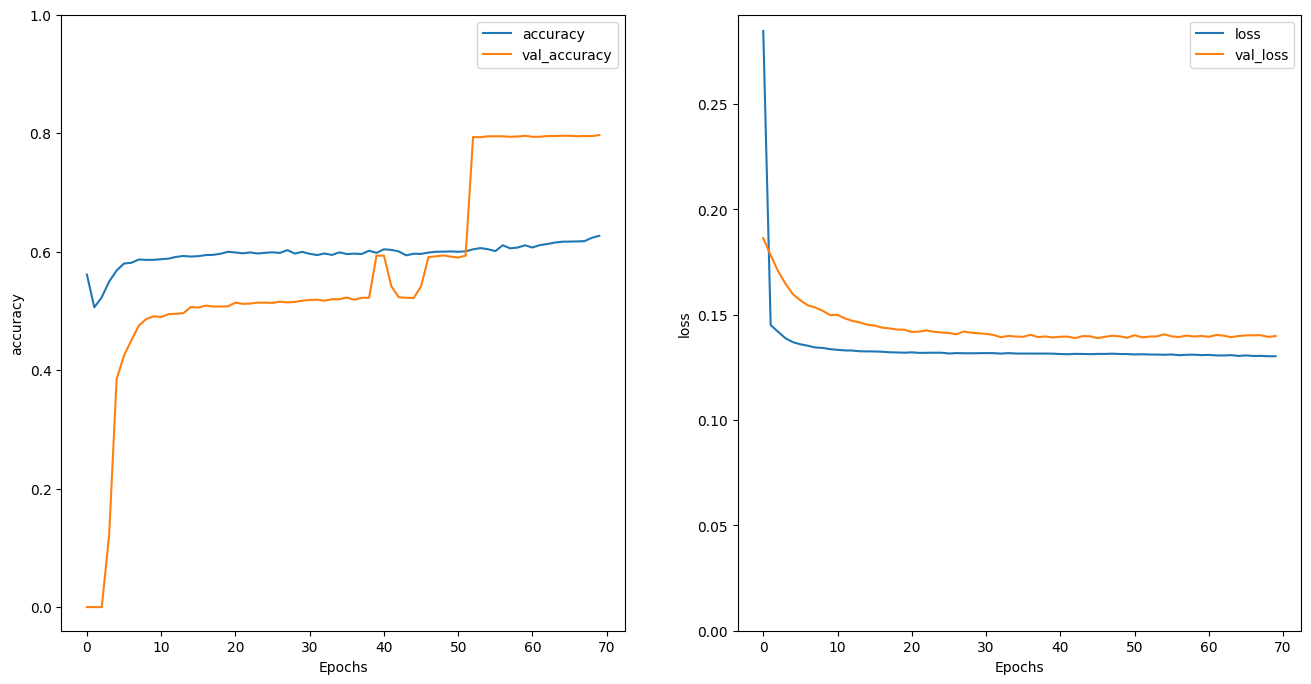

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [32]:

# predict on a sample text without padding
"""
predictions = model.predict((np.array([example_token]), np.array([example_type])))
print(predictions[0])
"""

'\npredictions = model.predict((np.array([example_token]), np.array([example_type])))\nprint(predictions[0])\n'

##### Experiment 2:

In [41]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, type_input_len, "float") # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [42]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 80
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [43]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "small-ordinary-unbalanced-all-inputs",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "multi_class_unbalanced_data_TOKENIZED_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
341/346 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.7719INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 14ms/step - loss: 0.1375 - accuracy: 0.7663 - val_loss: 0.2267 - val_accuracy: 0.0000e+00
Epoch 2/200
342/346 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.7452INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 13ms/step - loss: 0.1214 - accuracy: 0.7420 - val_loss: 0.2102 - val_accuracy: 0.0000e+00
Epoch 3/200
346/346 [==============================] - 4s 11ms/step - loss: 0.1221 - accuracy: 0.7341 - val_loss: 0.2143 - val_accuracy: 0.0000e+00
Epoch 4/200
346/346 [==============================] - 4s 11ms/step - loss: 0.1229 - accuracy: 0.7334 - val_loss: 0.2170 - val_accuracy: 0.0000e+00
Epoch 5/200
346/346 [==============================] - 4s 12ms/step - loss: 0.1261 - accuracy: 0.7199 - val_loss: 0.2137 - val_accuracy: 0.0000e+00
Epoch 6/200
346/346 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.6845INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 15ms/step - loss: 0.1299 - accuracy: 0.6845 - val_loss: 0.2071 - val_accuracy: 0.0000e+00
Epoch 7/200
342/346 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.6441INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 15ms/step - loss: 0.1364 - accuracy: 0.6408 - val_loss: 0.1916 - val_accuracy: 0.0000e+00
Epoch 8/200
341/346 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.5075INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 4s 12ms/step - loss: 0.1471 - accuracy: 0.5051 - val_loss: 0.1714 - val_accuracy: 0.0000e+00
Epoch 9/200
341/346 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.4172INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 13ms/step - loss: 0.1478 - accuracy: 0.4162 - val_loss: 0.1646 - val_accuracy: 0.0000e+00
Epoch 10/200
345/346 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.3832INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 13ms/step - loss: 0.1481 - accuracy: 0.3833 - val_loss: 0.1621 - val_accuracy: 0.0000e+00
Epoch 11/200
345/346 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.3767INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 13ms/step - loss: 0.1481 - accuracy: 0.3767 - val_loss: 0.1611 - val_accuracy: 0.0000e+00
Epoch 12/200
344/346 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.3728INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 15ms/step - loss: 0.1482 - accuracy: 0.3729 - val_loss: 0.1605 - val_accuracy: 0.0000e+00
Epoch 13/200
341/346 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.3704INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 4s 13ms/step - loss: 0.1482 - accuracy: 0.3707 - val_loss: 0.1601 - val_accuracy: 0.0000e+00
Epoch 14/200
342/346 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.3686INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 4s 13ms/step - loss: 0.1481 - accuracy: 0.3682 - val_loss: 0.1600 - val_accuracy: 0.0000e+00
Epoch 15/200
342/346 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.3658INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 4s 13ms/step - loss: 0.1482 - accuracy: 0.3657 - val_loss: 0.1596 - val_accuracy: 0.0000e+00
Epoch 16/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1482 - accuracy: 0.3676 - val_loss: 0.1597 - val_accuracy: 0.0000e+00
Epoch 17/200
342/346 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.3654INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 4s 13ms/step - loss: 0.1483 - accuracy: 0.3656 - val_loss: 0.1595 - val_accuracy: 0.0000e+00
Epoch 18/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.3619 - val_loss: 0.1597 - val_accuracy: 0.0000e+00
Epoch 19/200
343/346 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.3625INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230310_212126-qyqrkbrj/files/model-best/assets


346/346 [==============================] - 5s 16ms/step - loss: 0.1483 - accuracy: 0.3624 - val_loss: 0.1595 - val_accuracy: 0.0000e+00
Epoch 20/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1484 - accuracy: 0.3603 - val_loss: 0.1597 - val_accuracy: 0.0000e+00
Epoch 21/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.3614 - val_loss: 0.1596 - val_accuracy: 0.0000e+00
Epoch 22/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.3627 - val_loss: 0.1597 - val_accuracy: 0.0000e+00
Epoch 23/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.3625 - val_loss: 0.1600 - val_accuracy: 0.0000e+00
Epoch 24/200
346/346 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.3621 - val_loss: 0.1598 - val_accuracy: 0.0000e+00
Epoch 25/200
346/346 [==============================] - 4s 11ms/step - loss: 0.1483 - accuracy: 0.3605 - val_loss: 0.1601 - 

In [44]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

38/38 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.9922
Test Loss: 0.27707090973854065
Test Accuracy: 0.9921875


(0.0, 0.28485632985830306)

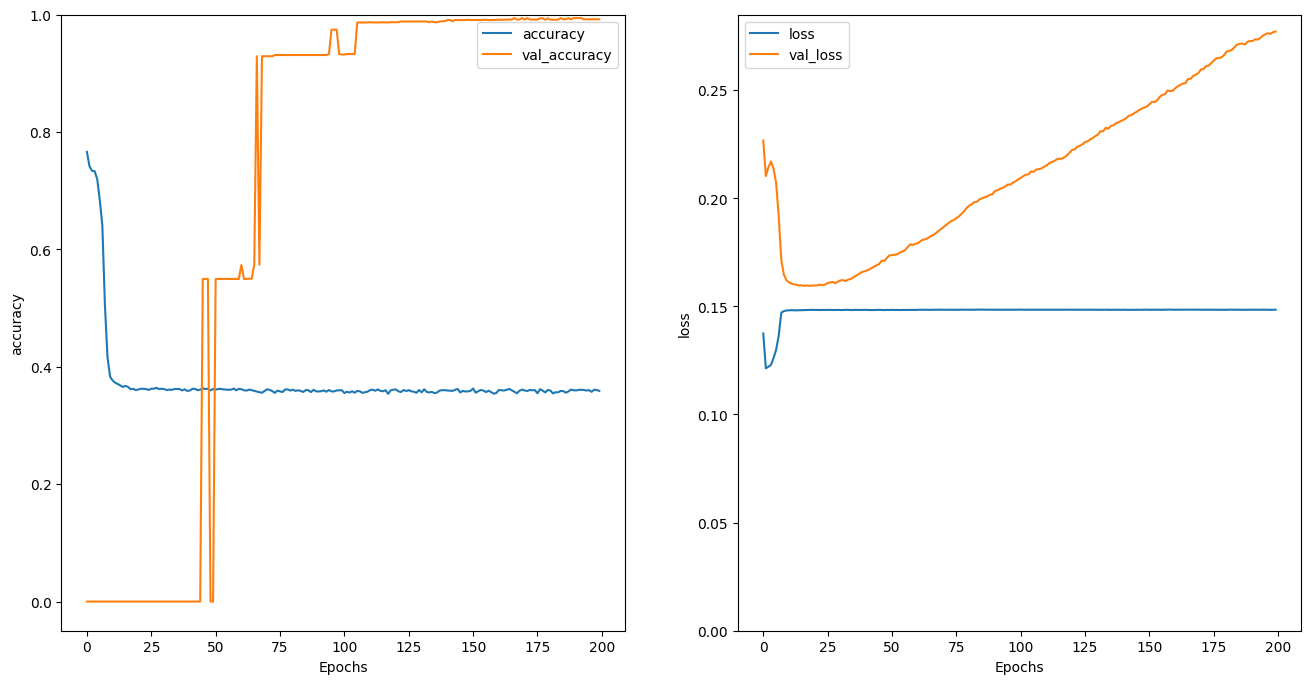

In [45]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [46]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'